In [1]:
import torch

def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

print('features:', features[0], '\nlabel:', labels[0])
import random
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i:min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break
#初始化模型参数
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l的形状是(batch_size, 1)，而不是一个标量
        # 所以所有元素被加到一起，并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
        with torch.no_grad():
            train_l = loss(net(features, w, b), labels)
            print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')




features: tensor([-0.1339, -0.7007]) 
label: tensor([6.3455])
tensor([[ 0.9743,  1.7360],
        [ 0.1337, -1.4287],
        [-0.2155,  0.0140],
        [-0.8579, -0.7122],
        [ 1.3757, -0.6265],
        [-2.0611, -1.5323],
        [ 0.7241, -0.3890],
        [ 0.9430, -0.1458],
        [ 0.8471, -1.6588],
        [ 0.7376, -0.8190]]) 
 tensor([[ 0.2359],
        [ 9.3275],
        [ 3.7197],
        [ 4.8894],
        [ 9.0716],
        [ 5.2749],
        [ 6.9907],
        [ 6.5839],
        [11.5418],
        [ 8.4433]])
epoch 1, loss 15.793286
epoch 1, loss 15.139772
epoch 1, loss 14.476084
epoch 1, loss 13.911137
epoch 1, loss 13.460445
epoch 1, loss 13.032758
epoch 1, loss 12.438618
epoch 1, loss 11.655386
epoch 1, loss 10.943165
epoch 1, loss 10.414420
epoch 1, loss 9.381446
epoch 1, loss 8.584443
epoch 1, loss 7.880129
epoch 1, loss 7.639671
epoch 1, loss 7.214921
epoch 1, loss 6.818350
epoch 1, loss 6.592729
epoch 1, loss 6.383248
epoch 1, loss 5.758404
epoch 1, loss 5.5

**3.3线性回归的简洁实现**

In [2]:
import numpy as np
import torch
from torch.utils import data


true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

next(iter(data_iter))
import torch.nn as nn
net=nn.Sequential(nn.Linear(2,1))
net[0].weight.data.normal_(0,0.01)
net[0].bias.data.fill_(0)
loss=nn.MSELoss()
trainer=torch.optim.SGD(net.parameters(),lr=0.03)
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')
w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)


epoch 1, loss 0.000201
epoch 2, loss 0.000107
epoch 3, loss 0.000107
w的估计误差： tensor([0.0008, 0.0004])
b的估计误差： tensor([0.0011])


**3.5 图像分类数据集 Fashion-Mnist**

In [3]:
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
import matplotlib.pyplot as plt

# -------------------------- 关键修改：更换国内镜像源 --------------------------
# 重写FashionMNIST的mirrors属性，使用阿里云国内源
torchvision.datasets.FashionMNIST.mirrors = [
    "https://mirrors.aliyun.com/apache/mxnet/example/gluon/datasets/fashion-mnist/"
]
# -----------------------------------------------------------------------------

# 数据转换：将PIL图像转为Tensor（并自动归一化到[0,1]）
trans = transforms.ToTensor()

# 加载训练集和测试集（此时会从阿里云源下载，速度更快）
# root：数据集保存路径（可自行修改，比如 "./data" 表示当前目录下的data文件夹）
mnist_train = torchvision.datasets.FashionMNIST(
    root="/home/pumengyu/2025_9python/data",  # 数据集保存路径，确保有读写权限
    train=True,      # True=训练集，False=测试集
    transform=trans, # 数据转换
    download=True    # 首次运行设为True（下载数据集），后续可设为False（直接加载本地）
)
mnist_test = torchvision.datasets.FashionMNIST(
    root="/home/pumengyu/2025_9python/data",
    train=False,
    transform=trans,
    download=True
)

# 验证加载成功：打印数据集大小和单张图像形状
print(f"训练集样本数：{len(mnist_train)}，测试集样本数：{len(mnist_test)}")
print(f"单张图像形状（通道数, 高度, 宽度）：{mnist_train[0][0].shape}")  # 输出 (1,28,28)，灰度图


# -------------------------- 以下是原有的标签转换和图像显示代码 --------------------------
def get_fashion_mnist_labels(labels):
    """返回Fashion-MNIST的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """绘制图像列表（无d2l依赖）"""
    figsize = (num_cols * scale, num_rows * scale)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()  # 转为1维数组，方便迭代
    
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 张量图像：(1,28,28) → 移除通道维度 → (28,28)
            ax.imshow(img.numpy().squeeze(), cmap="gray")  # cmap="gray"确保灰度显示
        else:
            # PIL图像直接显示
            ax.imshow(img, cmap="gray")
        
        ax.axis("off")  # 隐藏坐标轴
        if titles:
            ax.set_title(titles[i], fontsize=8)  # 调整标题字体大小，避免重叠
    
    return axes

# 加载一个批次（18张图）并显示
batch_size = 18
data_loader = data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
X, y = next(iter(data_loader))  # 获取第一个批次

# 显示2行9列的图像
show_images(X, num_rows=2, num_cols=9, titles=get_fashion_mnist_labels(y))
plt.show()  # 显式触发图像显示

RuntimeError: Error downloading train-images-idx3-ubyte.gz:
Tried https://mirrors.aliyun.com/apache/mxnet/example/gluon/datasets/fashion-mnist/, got:
<urlopen error [Errno -3] Temporary failure in name resolution>


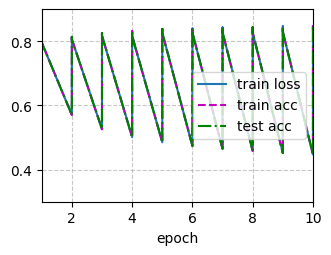

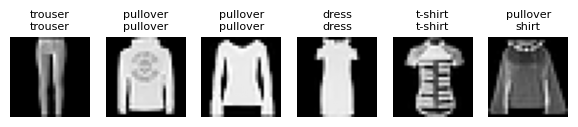

In [ ]:
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
import matplotlib.pyplot as plt
import os
import numpy as np
import struct  # 用于解析MNIST二进制文件

path="/home/pumengyu/2025_9python/download/"
# -------------------------- 核心：手动解析MNIST格式文件 --------------------------
def load_mnist_local(root, train=True, transform=None):
    """
    从本地读取MNIST格式的Fashion-MNIST数据集
    root: 数据集根路径（如 /home/pumengyu/2025_9python/data）
    train: True=加载训练集，False=加载测试集
    transform: 数据转换函数
    """
    # 1. 定义文件路径（与步骤2的结构对应）
    data_dir = os.path.join(root, "FashionMNIST", "raw")
    if train:
        img_path = os.path.join(data_dir, "train-images-idx3-ubyte")
        label_path = os.path.join(data_dir, "train-labels-idx1-ubyte")
    else:
        img_path = os.path.join(data_dir, "t10k-images-idx3-ubyte")
        label_path = os.path.join(data_dir, "t10k-labels-idx1-ubyte")
#binary二进制模式，rb以二进制模式只读打开
    # 2. 解析图像文件（MNIST格式：前16字节是头信息，后接像素数据）
    with open(img_path, "rb") as f:
        # 读取头信息：magic_number(4字节)、num_images(4字节)、num_rows(4字节)、num_cols(4字节)
        #>IIII，>是表示大端字节序,I表示无符号整数,">IIII"表示4个无符号整数，按大端字节序解析
        #f.read(16)表示从文件对象f中读取16字节的数据
        magic, num_imgs, rows, cols = struct.unpack(">IIII", f.read(16))
        # 读取像素字节流 → 转为NumPy数组（uint8：0-255）→ 再转为torch张量
        img_bytes = f.read()
        imgs = np.frombuffer(img_bytes, dtype=np.uint8)  # 字节流→NumPy数组（修复核心）
        imgs = torch.from_numpy(imgs)
        imgs=imgs.view(num_imgs, 1, rows, cols)
        imgs=imgs.float()  # 调整形状
        imgs = imgs / 255.0  # 归一化到[0,1]（模拟ToTensor效果）

    # 3. 解析标签文件（MNIST格式：前8字节是头信息，后接标签数据）
    with open(label_path, "rb") as f:
        # 读取头信息（2个无符号整数，大端序）
        magic, num_labels = struct.unpack(">II", f.read(8))
        # 标签字节流→NumPy数组→torch张量
        label_bytes = f.read()
        labels = np.frombuffer(label_bytes, dtype=np.uint8)  # 字节流→NumPy数组
        labels = torch.from_numpy(labels).view(num_labels).long()  # 转为长整型（分类标签常用）


    # 4. 应用数据转换（如ToTensor已手动实现，这里可加其他转换如Resize）
    if transform is not None:
        # 注意：transforms.ToTensor()会重复归一化，这里若用自定义transform需避免
        imgs = torch.stack([transform(img) for img in imgs])

    # 5. 返回数据集（用列表模拟Dataset，每个元素是(图像, 标签)）
    class LocalFashionMNIST(data.Dataset):
        def __len__(self):
            return len(imgs)
        def __getitem__(self, idx):
            return imgs[idx], labels[idx]
    
    return LocalFashionMNIST()


# -------------------------- 加载本地数据集 --------------------------
# 数据转换：这里只需保持图像格式，ToTensor的归一化已在load_mnist_local中实现
trans = transforms.Compose([
    # 可添加其他转换，如 transforms.Resize((32,32))（可选）
])

# 加载训练集和测试集（download=False，完全本地加载）
root = "/home/pumengyu/2025_9python/download/"# 你的数据集根路径
mnist_train = load_mnist_local(root=root, train=True, transform=trans)
mnist_test = load_mnist_local(root=root, train=False, transform=trans)

# 验证加载成功：打印数据集大小和单张图像形状
print(f"训练集样本数：{len(mnist_train)}（应为60000）")
print(f"测试集样本数：{len(mnist_test)}（应为10000）")
print(f"单张图像形状：{mnist_train[0][0].shape}（应为(1,28,28)）")


# -------------------------- 图像显示（与之前一致） --------------------------
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    figsize = (num_cols * scale, num_rows * scale)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        # 显示灰度图像
        ax.imshow(img.numpy().squeeze(), cmap="gray")
        ax.axis("off")
        if titles:
            ax.set_title(titles[i], fontsize=8)
    return axes

# 加载一个批次并显示
batch_size = 18
data_loader = data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
X, y = next(iter(data_loader))

# 显示2行9列图像
show_images(X, num_rows=2, num_cols=9, titles=get_fashion_mnist_labels(y))
plt.show()
batch_size=256
train_iter=data.DataLoader(mnist_train,batch_size,shuffle=True,num_workers=4)
test_iter=data.DataLoader(mnist_test,batch_size,shuffle=True,num_workers=4)
num_inputs=784
num_outputs=10
w=torch.normal(0,0.01,size=(num_inputs,num_outputs),requires_grad=True)
b=torch.zeros(num_outputs,requires_grad=True)
# 关于sum运算的示例代码
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
x1=X.sum(0, keepdim=True)
x2=X.sum(1, keepdim=True)
print("x1=",x1)
print("x2=",x2)
print("x1.shape",x1.shape)
print(X.sum(0).shape)
# softmax函数定义
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition  # 这里应用了广播机制

# softmax函数测试示例
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)
def net(x):
    return softmax(torch.matmul(x.reshape(-1,w.shape[0]),w)+b)
# 交叉熵损失函数相关代码
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]
print("y_hat",y_hat)
print("len1=",len(y_hat))
print("len=",range(len(y_hat)))
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])
y1=y_hat[[0,1],y]
print("y1",y1)

cross_entropy(y_hat, y)


y=y_hat.argmax(axis=1)
print("y=",y)

# 分类精度函数代码
def accuracy(y_hat, y):  # @save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

# 计算分类精度（单样本精度计算）
accuracy(y_hat, y) / len(y)

# 评估数据集上的模型精度
def evaluate_accuracy(net, data_iter):  # @save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

# 累加器类，用于多个变量的累加
class Accumulator:  # @save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# 测试模型初始精度（示例）
evaluate_accuracy(net, test_iter)

#训练一轮模型的函数
def train_epoch_ch3(net, train_iter, loss, updater):  # @save
    """训练模型一轮（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练过程中统计指标的代码
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            l.sum().backward()
            updater(X.shape[0])
        metric.add(l.sum(), accuracy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]

# 绘图实用类 Animator
import matplotlib.pyplot as plt
from IPython.display import display, clear_output  # 替代d2l的动态显示


# 1. 替代 d2l.set_axes：配置坐标轴（实现原d2l.set_axes的所有功能）
def set_axes(axes, xlabel=None, ylabel=None, xlim=None, ylim=None,
             xscale='linear', yscale='linear', legend=None):
    """
    配置matplotlib坐标轴的样式和属性
    参数与原d2l.set_axes完全一致：
    - axes: 要配置的坐标轴对象
    - xlabel/ylabel: x/y轴标签
    - xlim/ylim: x/y轴的显示范围（如[0, 10]）
    - xscale/yscale: 轴的刻度类型（'linear'线性，'log'对数）
    - legend: 图例（列表形式，如['train loss', 'test loss']）
    """
    # 设置轴标签
    if xlabel:
        axes.set_xlabel(xlabel)
    if ylabel:
        axes.set_ylabel(ylabel)
    # 设置轴范围
    if xlim:
        axes.set_xlim(xlim)
    if ylim:
        axes.set_ylim(ylim)
    # 设置轴刻度类型
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    # 设置图例
    if legend:
        axes.legend(legend)
    # 显示网格（原d2l.set_axes默认有网格，保持一致）
    axes.grid(True, linestyle='--', alpha=0.7)

import IPython.display as ipd
# 2. 重构Animator类：移除d2l依赖，用原生库实现
class Animator:
    """在动画中动态绘制数据（无d2l依赖，基于matplotlib和IPython.display）"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 1. 替代d2l.use_svg_display()：设置图像以SVG格式显示（清晰且轻量化）
        plt.rcParams['savefig.format'] = 'svg'
        
        # 2. 替代d2l.plt.subplots：创建画布和坐标轴（原生matplotlib）
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        
        # 处理单坐标轴场景：确保axes是列表（统一后续代码逻辑）
        if nrows * ncols == 1:
            self.axes = [self.axes, ]  # 转为列表，避免后续索引报错
        
        # 3. 替代d2l.set_axes：用自定义的set_axes配置坐标轴（通过lambda捕获参数）
        self.config_axes = lambda: set_axes(
            self.axes[0],  # 目前只支持单子图（与原d2l版本一致）
            xlabel=xlabel, ylabel=ylabel, xlim=xlim, ylim=ylim,
            xscale=xscale, yscale=yscale, legend=legend
        )
        
        # 初始化存储数据的列表（X/Y分别对应多条线的x/y坐标）
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        """向图表中添加多个数据点（支持单条/多条线同时更新）"""
        # 处理y：若y不是可迭代对象（如单个数值），转为列表（统一格式）
        if not hasattr(y, "__len__"):  # 判断是否有len()方法（可迭代的标志）
            y = [y]
        n = len(y)  # 线的数量
        
        # 处理x：若x不是可迭代对象，生成与y长度一致的x列表（每条线用相同x）
        if not hasattr(x, "__len__"):
            x = [x] * n
        
        # 初始化X/Y：若未初始化，创建n个空列表（对应n条线）
        if not self.X:  # self.X为None时初始化
            self.X = [[], ] * n  # 每条线的x坐标列表
        if not self.Y:
            self.Y = [[], ] * n  # 每条线的y坐标列表
        
        # 追加新数据到X/Y（只保留非None的数据，避免绘图错误）
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)  # 第i条线的x增加a
                self.Y[i].append(b)  # 第i条线的y增加b
        
        # 清空当前坐标轴（避免旧图残留）
        self.axes[0].cla()  # clear axes
        
        # 绘制所有线（按X/Y/fmts对应关系绘图）
        for x_line, y_line, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x_line, y_line, fmt)  # fmt是线条格式（如'-'实线，'m--'品红虚线）
        
        # 配置坐标轴（应用xlabel/ylabel/legend等）
        self.config_axes()
        
        # 动态显示与刷新：替代d2l的动态逻辑（先显示画布，再清空输出等待下一次更新）
        ipd.display(self.fig)  # 显示当前画布
        ipd.clear_output(wait=True)  # 清空输出（wait=True：等待下一次更新再清空，避免闪烁）
# 训练模型并可视化训练进度
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  # @save
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
        train_loss, train_acc = train_metrics
        assert train_loss < 0.8, train_loss
        assert train_acc <= 1 and train_acc > 0.7, train_acc
        assert test_acc <= 1 and test_acc > 0.7, test_acc

# 定义优化器（小批量随机梯度下降）
# -------------------------- 1. 实现自定义SGD优化器（替代d2l.sgd） --------------------------
def sgd(params, lr, batch_size):
    """
    小批量随机梯度下降（Mini-Batch SGD）：更新模型参数
    params: 待更新的参数列表（如 [w, b]）
    lr: 学习率（控制更新步长）
    batch_size: 批量大小（用于梯度平均，避免批量大小影响更新幅度）
    """
    with torch.no_grad():  # 禁止梯度计算，避免更新参数时修改计算图
        for param in params:
            # 核心更新逻辑：参数 = 参数 - 学习率 × 平均梯度（梯度/批量大小）
            param.data -= lr * param.grad / batch_size
            # 清零梯度：避免下一次迭代时梯度累积（否则梯度会叠加，导致更新异常）
            param.grad.data.zero_()
# -------------------------- 2. 定义优化器（调用自定义SGD，替代d2l.sgd） --------------------------
lr = 0.1  # 学习率（控制更新步长，可调整）
def updater(batch_size):
    # 调用自定义的sgd，参数列表是 [w, b]（与你之前定义的参数名一致，小写w！）
    return sgd([w, b], lr, batch_size)


# -------------------------- 3. 预测图像类别（复用已有函数，替代d2l版本） --------------------------
def predict_ch3(net, test_iter, n=6):
    """预测测试集图像的类别，并显示“真实标签vs预测标签”"""
    # 从测试集中取第一个批次的数据（只取一次，用于演示）
    for X, y in test_iter:
        break  # 取完第一个批次就退出循环，避免遍历所有数据
    
    # ① 转换标签为文本（复用你已有get_fashion_mnist_labels函数）
    trues = get_fashion_mnist_labels(y)  # 真实标签（文本）
    preds = get_fashion_mnist_labels(net(X).argmax(axis=1))  # 预测标签（文本）
    
    # ② 组合标签（真实标签换行显示预测标签，方便对比）
    titles = [f"{true}\n{pred}" for true, pred in zip(trues, preds)]
    
    # ③ 显示图像（复用你已有show_images函数，补充plt.show()确保显示）
    show_images(
        imgs=X[0:n],  # 取前n个测试样本（形状：(n,1,28,28)，show_images内部会自动去掉通道维度）
        num_rows=1,   # 1行显示n个样本
        num_cols=n,   # n列显示n个样本
        titles=titles[0:n],  # 前n个样本的“真实vs预测”标签
        scale=1.2     # 调整图像大小，避免标签重叠
    )
    plt.show()  # 显式触发图像显示（你原有show_images没加这个，这里补充）
    
# -------------------------- 4. 训练模型（调用train_ch3，已无d2l依赖） --------------------------
# 训练轮数（可调整，10轮足够看到收敛）
num_epochs = 10
# 调用训练函数：net（模型）、train_iter（训练数据）、test_iter（测试数据）、cross_entropy（损失）、num_epochs（轮数）、updater（优化器）
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

# -------------------------- 5. 预测测试集类别（调用自定义predict_ch3） --------------------------
predict_ch3(net, test_iter, n=6)  # 显示6个测试样本的“真实标签vs预测标签”

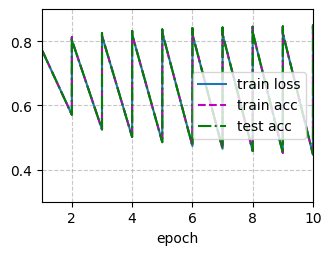

In [ ]:
net=nn.Sequential(nn.Flatten(),nn.Linear(784,10))

def init_weights(m):
    if type(m)==nn.Linear:
        nn.init.normal_(m.weight,std=0.01)
net.apply(init_weights)
loss=nn.CrossEntropyLoss(reduction='none')
trainer=torch.optim.SGD(net.parameters(),lr=0.1)
num_epochs=10
train_ch3(net,train_iter,test_iter,loss,num_epochs,trainer)